In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC
from sklearn.metrics import plot_confusion_matrix,classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud
from matplotlib.colors import ListedColormap

In [3]:
df = pd.read_csv('/content/sample_data/Tweets.csv')

In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df.tail()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)
14639,569587140490866689,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know h...,NaN,2015-02-22 11:58:51 -0800,"dallas, TX",NaN


In [6]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [8]:
df.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [9]:
def resizeplot(x,y,d):
    plt.figure(figsize=(x,y),dpi=d)

Ok, now we gonna create a imputer to fill the nan data from the float columns. Remember: Imputation for completing missing values using k-Nearest Neighbors. Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set. Two samples are close if the features that neither is missing are close.

In [10]:
imputer = KNNImputer(missing_values=float ,n_neighbors=5,metric='nan_euclidian',weights='uniform')

In [11]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

There are other categorical features that has many 'nan' data. I'll perform a feature engineering filling with 'unknown' data for the best visualization of our analisys. Check this out.

In [12]:
df['negativereason'].fillna('unknown',inplace=True)

In [13]:
df['negativereason_confidence'].mean()

0.6382982797947114

In [14]:
df['negativereason_confidence'].unique()

array([   nan, 0.    , 0.7033, ..., 0.6234, 0.644 , 0.7255])

In [15]:
df['negativereason_confidence'].fillna(0,inplace=True)

In [16]:
df['negativereason_confidence'].unique()

array([0.    , 0.7033, 1.    , ..., 0.6234, 0.644 , 0.7255])

In [17]:
df['negativereason_confidence'] = imputer.fit_transform(df[['negativereason_confidence']])

In [18]:
df['airline_sentiment_gold'].unique()

array([nan, 'negative', 'neutral', 'positive'], dtype=object)

In [19]:
df['negativereason_gold'].fillna('unknown',inplace=True)

In [20]:
df['airline_sentiment_gold'].fillna('unknown',inplace=True)

In [21]:
df['tweet_location'].fillna('unknown',inplace=True)

In [22]:
df['tweet_coord'].fillna('unknown',inplace=True)

In [23]:
df['user_timezone'].fillna('unknown',inplace=True)

In [24]:
df['negativereason_gold'].value_counts()

unknown                                     14608
Customer Service Issue                         12
Late Flight                                     4
Cancelled Flight                                3
Can't Tell                                      3
Cancelled Flight\nCustomer Service Issue        2
Late Flight\nLost Luggage                       1
Late Flight\nCancelled Flight                   1
Lost Luggage\nDamaged Luggage                   1
Flight Attendant Complaints                     1
Customer Service Issue\nLost Luggage            1
Customer Service Issue\nCan't Tell              1
Bad Flight                                      1
Late Flight\nFlight Attendant Complaints        1
Name: negativereason_gold, dtype: int64

In [25]:
df['airline_sentiment_gold'].value_counts()

unknown     14600
negative       32
positive        5
neutral         3
Name: airline_sentiment_gold, dtype: int64

In [26]:
df.isnull().sum()

tweet_id                        0
airline_sentiment               0
airline_sentiment_confidence    0
negativereason                  0
negativereason_confidence       0
airline                         0
airline_sentiment_gold          0
name                            0
negativereason_gold             0
retweet_count                   0
text                            0
tweet_coord                     0
tweet_created                   0
tweet_location                  0
user_timezone                   0
dtype: int64

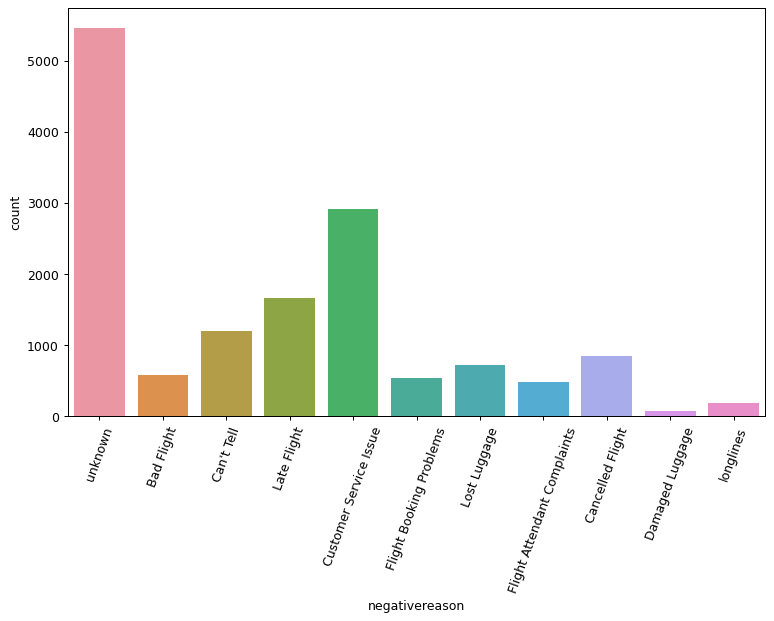

In [27]:
resizeplot(10,6,90)
plt.xticks(rotation=70);
sns.countplot(x='negativereason',data=df)

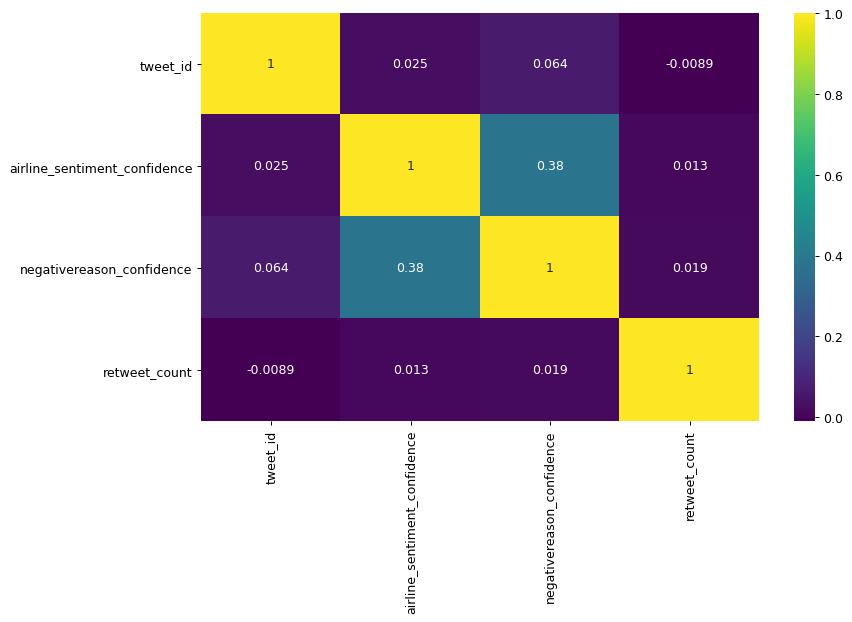

In [28]:
resizeplot(10,6,90)
sns.heatmap(df.corr(),cmap='viridis',annot=True)

In [29]:
df.drop('tweet_id',axis=1,inplace=True)

In [30]:
df.groupby('airline_sentiment').describe().transpose()

airline_sentiment                      negative      neutral     positive
airline_sentiment_confidence count  9178.000000  3099.000000  2363.000000
                             mean      0.933365     0.823303     0.872039
                             std       0.138109     0.185594     0.179478
                             min       0.339400     0.335000     0.335600
                             25%       1.000000     0.666050     0.677500
                             50%       1.000000     0.916000     1.000000
                             75%       1.000000     1.000000     1.000000
                             max       1.000000     1.000000     1.000000
negativereason_confidence    count  9178.000000  3099.000000  2363.000000
                             mean      0.731769     0.000000     0.000000
                             std       0.238276     0.000000     0.000000
                             min       0.312200     0.000000     0.000000
                             25%       0.645300     0.000000     0.000000
                             50%       0.680600     0.000000     0.000000
                             75%       1.000000     0.000000     0.000000
                             max       1.000000     0.000000     0.000000
retweet_count                count  9178.000000  3099.000000  2363.000000
                             mean      0.093375     0.060987     0.069403
                             std       0.792865     0.658037     0.659914
                             min       0.000000     0.000000     0.000000
                             25%       0.000000     0.000000     0.000000
                             50%       0.000000     0.000000     0.000000
                             75%       0.000000     0.000000     0.000000
                             max      44.000000    28.000000    22.000000

In [31]:
pd.DataFrame(df[['airline_sentiment','airline']].value_counts(),columns=['rated'])

rated
airline_sentiment airline              
negative          United           2633
                  US Airways       2263
                  American         1960
                  Southwest        1186
                  Delta             955
neutral           Delta             723
                  United            697
                  Southwest         664
positive          Southwest         570
                  Delta             544
                  United            492
neutral           American          463
                  US Airways        381
positive          American          336
                  US Airways        269
negative          Virgin America    181
neutral           Virgin America    171
positive          Virgin America    152

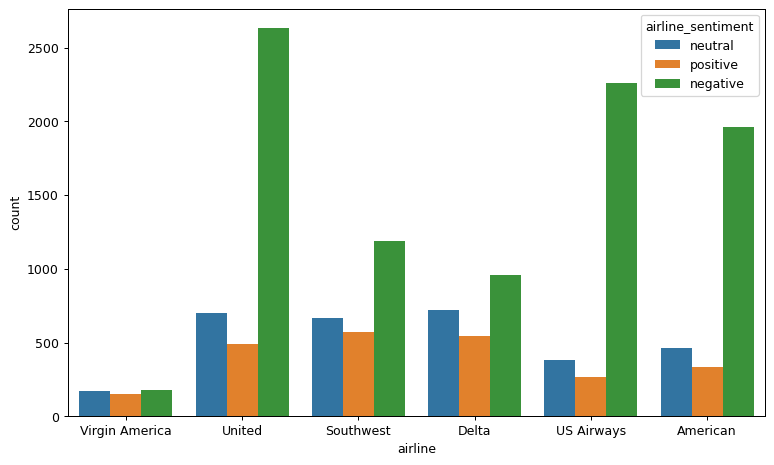

In [32]:
resizeplot(10,6,90)
sns.countplot(x='airline',hue='airline_sentiment',data=df)

In [33]:
pd.DataFrame(df[['airline_sentiment','tweet_location','airline']].value_counts(),columns=['Rated']).head(30)

Rated
airline_sentiment tweet_location    airline              
negative          unknown           United            844
                                    US Airways        836
                                    American          685
                                    Southwest         401
                                    Delta             321
neutral           unknown           Southwest         240
                                    United            223
positive          unknown           Southwest         183
neutral           unknown           Delta             159
                                    US Airways        151
                                    American          144
positive          unknown           Delta             138
                                    United            122
                                    American           82
                                    US Airways         82
neutral           USA               Delta              62
negative          unknown           Virgin America     55
neutral           unknown           Virgin America     45
negative          Washington, D.C.  US Airways         37
                  Washington, DC    US Airways         36
                  San Francisco, CA United             34
                  Boston, MA        US Airways         31
                  New York, NY      American           30
                  New York          United             28
                  Boston, MA        Delta              28
                  Pekin             American           28
                  San Francisco     United             27
                  Chicago, IL       United             27
                  Houston, TX       United             26
                  New York City     Delta              25

In [34]:
df['tweet_location'].unique()

array(['unknown', 'Lets Play', 'San Francisco CA', ...,
       'Columbus, OH, USA', 'Milwaukee County, Wisconsin',
       'Nigeria,lagos'], dtype=object)

(-0.5, 399.5, 199.5, -0.5)

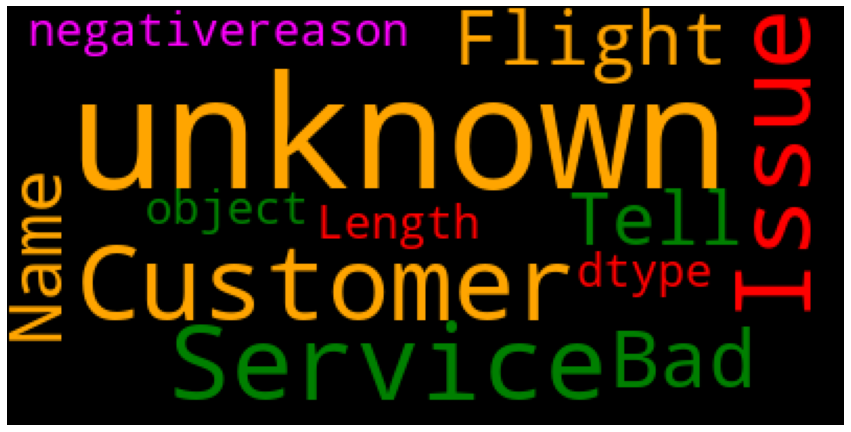

In [35]:
color_map = ListedColormap(['orange','green','red','magenta'])
cloud = WordCloud(background_color='black',max_words = 100,colormap=color_map)
review = df['negativereason']
cloud = cloud.generate(str(review))
plt.figure(figsize=(15,15))
plt.imshow(cloud)
plt.axis('off')

In [36]:
data = df[['airline_sentiment','text']]

In [37]:
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [38]:
X = data['text']
y = data['airline_sentiment']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

In [40]:
tfid = TfidfVectorizer(stop_words='english')

tfid.fit(X_train)

X_train_tfid = tfid.transform(X_train)
X_test_tfid = tfid.transform(X_test)

In [41]:
X_train_tfid

<10980x12530 sparse matrix of type '<class 'numpy.float64'>'
	with 100627 stored elements in Compressed Sparse Row format>

In [42]:
#MULTINOMIAL NB

nb = MultinomialNB()

nb.fit(X_train_tfid,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [43]:
#LOGISTIC REGRESSION

#lr = LogisticRegression(solver='saga',multi_class='ovr',max_iter = 1000)
lr = LogisticRegression(max_iter = 1000)
lr.fit(X_train_tfid,y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
#grid_model.fit(X_train_tfid,y_train)
lr.fit(X_train_tfid,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
#SVC

svc = SVC()

svc.fit(X_train_tfid,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [46]:
#DECISION TREE

dt = DecisionTreeClassifier()
dt.fit(X_train_tfid,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [47]:
#METRICS FUNCTION

def report(model):
    preds =model.predict(X_test_tfid)
    print(classification_report(y_test,preds))
    plot_confusion_matrix(model,X_test_tfid,y_test)

Testing the metrics.

              precision    recall  f1-score   support

    negative       0.67      0.99      0.80      2312
     neutral       0.78      0.14      0.23       769
    positive       0.88      0.16      0.27       579

    accuracy                           0.68      3660
   macro avg       0.78      0.43      0.44      3660
weighted avg       0.73      0.68      0.60      3660



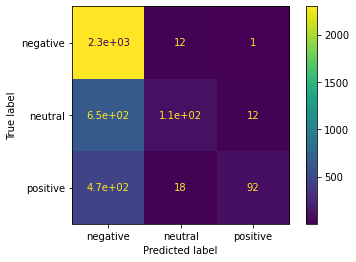

In [48]:
#MULTINOMIALNB

report(nb)

              precision    recall  f1-score   support

    negative       0.80      0.93      0.86      2312
     neutral       0.66      0.45      0.54       769
    positive       0.77      0.60      0.67       579

    accuracy                           0.78      3660
   macro avg       0.75      0.66      0.69      3660
weighted avg       0.77      0.78      0.77      3660



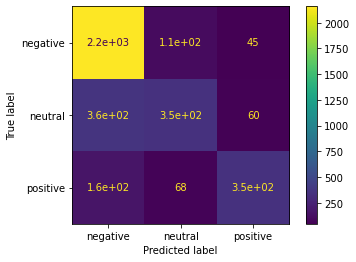

In [49]:
#LOGISTIC_REGRESSION_MODEL

report(lr)

              precision    recall  f1-score   support

    negative       0.79      0.96      0.86      2312
     neutral       0.71      0.38      0.49       769
    positive       0.78      0.59      0.67       579

    accuracy                           0.78      3660
   macro avg       0.76      0.64      0.68      3660
weighted avg       0.77      0.78      0.76      3660



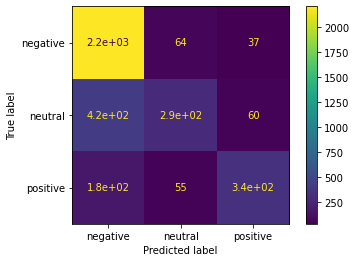

In [50]:
#SVC MODEL

report(svc)

              precision    recall  f1-score   support

    negative       0.77      0.80      0.79      2312
     neutral       0.41      0.38      0.39       769
    positive       0.59      0.55      0.57       579

    accuracy                           0.67      3660
   macro avg       0.59      0.58      0.58      3660
weighted avg       0.67      0.67      0.67      3660



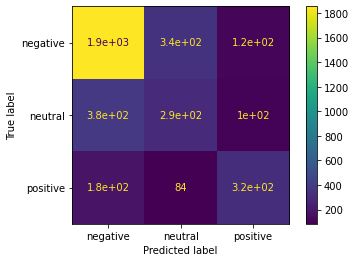

In [51]:
# DECISION TREE MODEL

report(dt)

In [52]:
pipe = Pipeline([('tfid',TfidfVectorizer()),('LR',LogisticRegression())])

In [53]:
pipe.fit(X,y)

Pipeline(memory=None,
         steps=[('tfid',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('LR',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1

In [54]:
pipe.predict(['ok flight'])

array(['neutral'], dtype=object)